In [107]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/SOLO')
sys.path.append(str(base))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [108]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/SOLO/mmdetection")
os.listdir()

['annotations',
 'val2017',
 'train2017',
 'kitti_tiny',
 'kitti_tiny.zip',
 '.git',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.readthedocs.yml',
 'LICENSE',
 'README.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmdet',
 'pytest.ini',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmdet.egg-info',
 'checkpoints',
 'tutorial_exps',
 'coco',
 'fix_autoencoder.pth']

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

from PIL import Image

from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data

import tqdm
from torchsummary import summary
import seaborn as sns

In [ ]:

!pip freeze --local > colab_installed.txt


In [ ]:
!pip install --upgrade --force-reinstall `cat /content/gdrive/My\ Drive/colab_installed.txt`


In [ ]:
!pip uninstall mmcv-full


In [4]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/WXinlong/mmdetection.git -b SOLO
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 27kB/s 
     |████████████████████████████████| 6.6MB 5.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 256kB 13.0MB/s 
     |████████████████████████████████| 194kB 43.5MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.1-cp36-cp36m-linux_x86_64.whl size=20441830 sha256=d97e9bde8b8f3219def1ea1d9ddf0ba824f8aafd2dc6edbc9b82ffd66d5bd9f0
  Stored in directory: /root/.cache/pip/wheels/41/0b/39/0cec97174407144208eed51efda0169de0860c0b8460ed0855
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 12705, done.
remote: Total 12705 (delta 0), reused 0 (del

In [30]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.3.0
10.1
GCC 7.5


###Test mmdetection

In [ ]:
!mkdir checkpoints
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2020-11-24 14:04:06--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.60.71
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.60.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  33.8MB/s    in 5.6s    

2020-11-24 14:04:12 (30.5 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [31]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot


In [ ]:
# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/mmcv/ops/deprecated_wrappers.py:13: UserWarning: Importing Conv2d wrapper from "mmcv.ops" will be deprecated in the future. Please import them from "mmcv.cnn" instead
  'Importing Conv2d wrapper from "mmcv.ops" will be deprecated in'


In [ ]:

# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

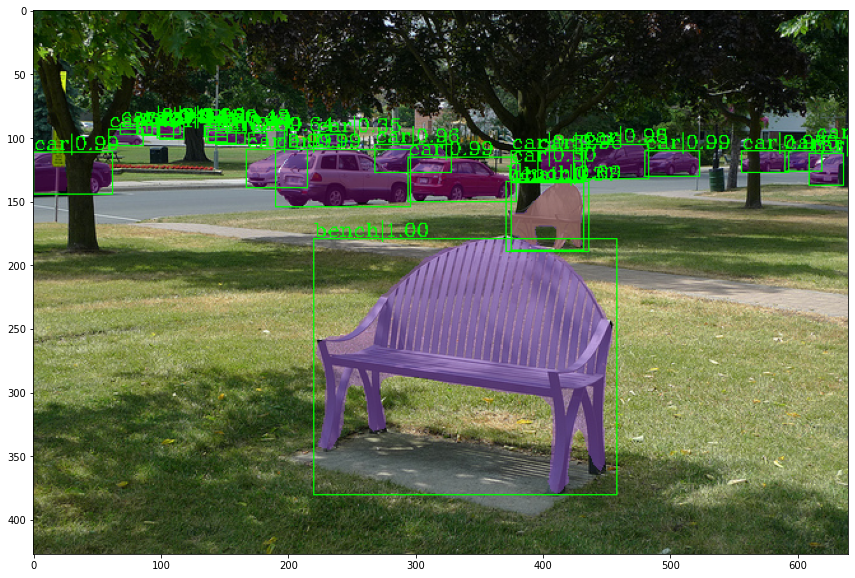

In [ ]:
show_result_pyplot(model, img, result, score_thr=0.3)


##Test dataset

In [ ]:
# download, decompress the data
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2020-11-24 14:15:44--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.58.79
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.58.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  11.4MB/s    in 0.6s    

2020-11-24 14:15:45 (11.4 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [ ]:

# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (46.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 0

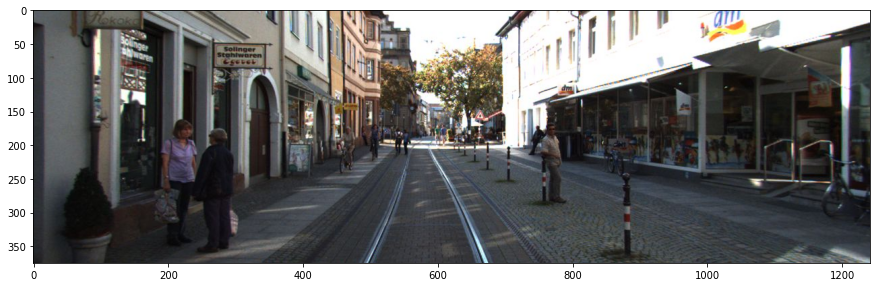

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()


In [ ]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

KeyError: ignored

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/solo/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')
#cfg = Config.fromfile('./configs/solo/solo_r50_fpn_1x_coco.py')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-11-24 14:22:40,997 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/checkpoints/resnet50_msra-5891d200.pth


2020-11-24 14:22:47,009 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias



2020-11-24 14:22:47,527 - mmdet - INFO - load checkpoint from checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2020-11-24 14:22:47,854 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
unexpected key in source state_dict: roi_head.mask_head.conv

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 4.3 task/s, elapsed: 6s, ETA:     0s

2020-11-24 14:27:50,723 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 140  | 0.968  | 0.881 |
| Pedestrian | 13  | 58   | 0.846  | 0.734 |
| Cyclist    | 7   | 73   | 0.571  | 0.046 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.554 |
+------------+-----+------+--------+-------+
2020-11-24 14:27:50,726 - mmdet - INFO - Epoch(val) [12][25]	mAP: 0.5536


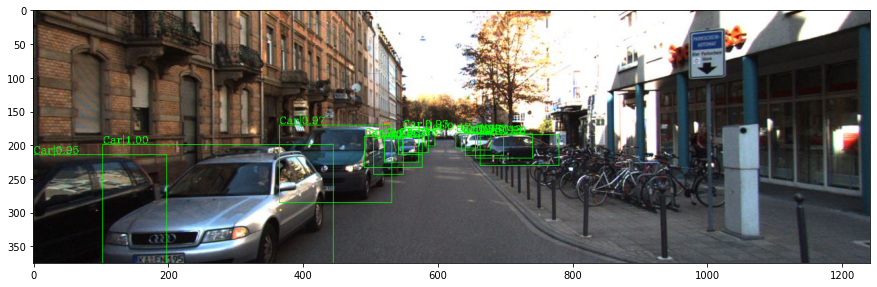

In [ ]:

img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

##Test solo

In [32]:
from mmdet.apis import init_detector, inference_detector
import mmcv
from mmcv import Config


config_file = Config.fromfile('configs/solo/del_true_solo_r50_fpn_1x_coco.py')
checkpoint_file = 'checkpoints/SOLO_R50_1x (1).pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')



In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()])


In [ ]:
img = torch.Tensor(transform(mmcv.imread('kitti_tiny/training/image_2/000068.jpeg').transpose((2,0,1)))).cuda()
img.shape

torch.Size([3, 224, 224])

In [33]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [38]:
#dataDir='./COCOdataset2017'
dataType='val'
annFile='annotations/instances_{}2017.json'.format(dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=1.74s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

In [171]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(77, cats))

The class name is cell phone


Number of images containing all the  classes: 11


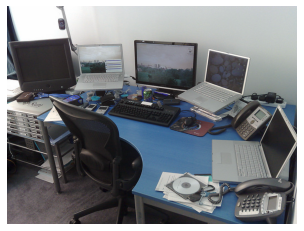

In [83]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['laptop', 'tv', 'cell phone']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
#I = io.imread('{}2017/{}'.format(dataType,img['file_name']))/255.0
I = mmcv.imread('{}2017/{}'.format(dataType,img['file_name']))

plt.axis('off')
plt.imshow(I)
plt.show()

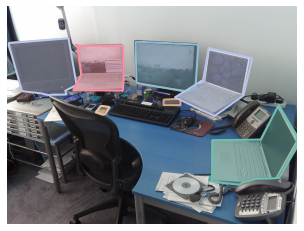

In [84]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [173]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()])
img = torch.Tensor(I).cuda()


In [90]:
res = model.forward_dummy(img.unsqueeze(0).permute((0,3,1,2))) #bbox_result, segm_result
#res = model.forward(img.unsqueeze(0).permute((0,3,1,2)), anns)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [88]:
result = inference_detector(model, I)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
for i, r in enumerate(res[0]):
  res[0][i] = r.cpu().detach().numpy()
for i, r in enumerate(res[1]):
  res[1][i] = r.cpu().detach().numpy()

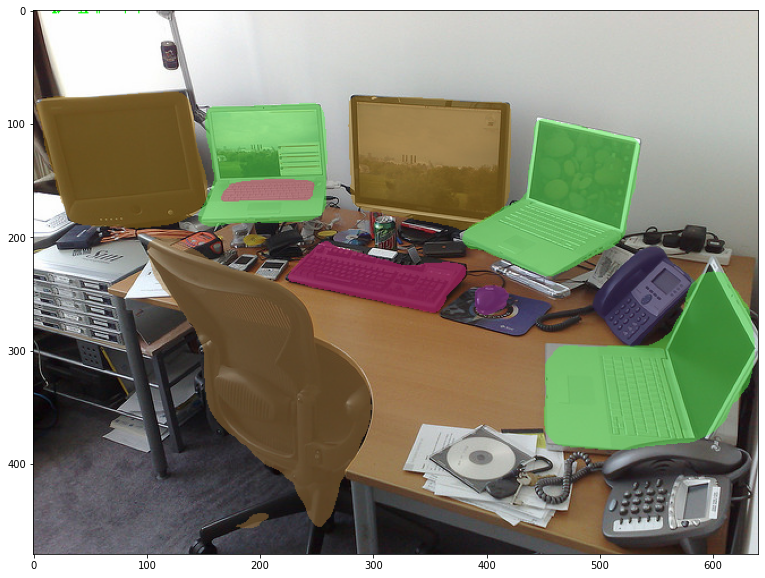

In [93]:
show_result_pyplot(model, I, result, score_thr=0.3)


##Add autoencoder


In [104]:
# in progress
class FixedAutoencoder(nn.Module):
  def __init__(self):
        super(FixedAutoencoder, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        # expand hidden
        self.exp1 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.exp2 = nn.ConvTranspose2d(128, 64, 3, padding=1)

        # decoder layers
        self.dec4 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.dec3 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.dec20 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.dec21 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec22 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec1 = nn.ConvTranspose2d(64, 1, 3, padding=1)

        self.sigm = nn.Sigmoid()
        self.hid_repr = nn.AdaptiveMaxPool2d((8,8), return_indices=True)
    
  def forward(self, x):
        # encode
        dim0 = x.size()
        x = self.relu(self.conv1(x))
        x1, i1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        dim1 = x1.size()
        x1 = self.relu(self.conv2(x1))
        x2, i2 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)
 
        dim2 = x2.size()
        x2 = self.relu(self.conv3(x2))
        x3, i3 = F.max_pool2d(x2, kernel_size=2, stride=2, return_indices=True)

        dim3 = x3.size()
        x3 = self.relu(self.conv4(x3))
        x4, i4 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)

        # hidden with fixed size 
        x_hid, i_hid = self.hid_repr(x4)

        # expand
        x_hid = F.max_unpool2d(x_hid, i_hid, kernel_size=2, stride=2)
        x3 = F.interpolate(x_hid, dim2[-2:])

        # decode
       # x2 = F.max_unpool2d(x3, i2, kernel_size=2, stride=2, output_size=dim1)
        x2 = self.relu(self.dec2(x3))
        x2 = self.relu(self.dec20(x2))
        x2 = self.relu(self.dec21(x2))
        x2 = self.relu(self.dec22(x2))

        x1 = F.max_unpool2d(x1, i1, kernel_size=2, stride=2, output_size=dim0)
        x = self.sigm(self.dec1(x1))
        return x

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = FixedAutoencoder().to(device)
autoencoder.load_state_dict(torch.load('fix_autoencoder.pth'))


<All keys matched successfully>

In [161]:
enc_result = autoencoder(torch.Tensor([masks[60][3]]).unsqueeze(0).to(device))

In [138]:
masks = np.array([np.array(r).astype(np.float64) for r in result[-1]])

In [191]:
mask_idx = [i for i, r in enumerate(result[1]) if r]

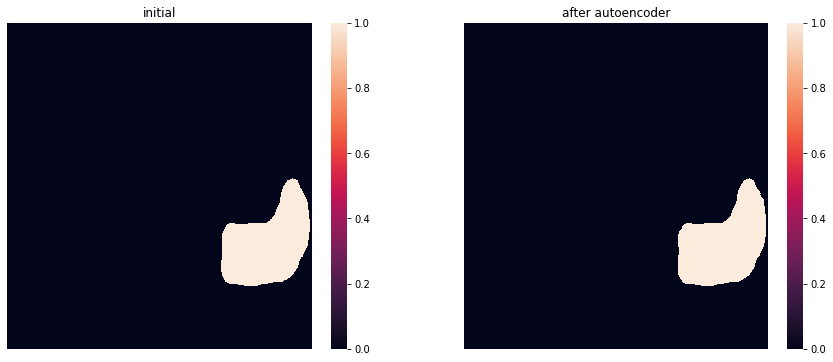

In [194]:
fig = plt.figure(figsize=(15,6))
fig.add_subplot(1, 2, 1)
plt.title('initial')
plt.axis('off')
#all_masks = np.zeros(masks[63][2].shape)
#for idx in mask_idx:
mask = masks[63][1]
sns.heatmap(mask, linewidth=0, xticklabels=False, yticklabels=False);

fig.add_subplot(1, 2, 2)
enc_mask = autoencoder(torch.Tensor([mask]).unsqueeze(0).to(device))
plt.title('after autoencoder')
plt.axis('off')
sns.heatmap(enc_mask.squeeze().cpu().detach().numpy(), linewidth=0, xticklabels=False, yticklabels=False);
  

In [175]:
summary(autoencoder, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 112, 112]          36,928
              ReLU-4         [-1, 64, 112, 112]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
              ReLU-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
              ReLU-8          [-1, 256, 28, 28]               0
 AdaptiveMaxPool2d-9  [[-1, 256, 8, 8], [-1, 256, 8, 8]]               0
  ConvTranspose2d-10          [-1, 128, 56, 56]         295,040
             ReLU-11          [-1, 128, 56, 56]               0
  ConvTranspose2d-12           [-1, 64, 56, 56]          73,792
             ReLU-13           [-1, 64, 56, 56]               0
  ConvTranspose2d-14          